In [3]:
import numpy as np
import cartopy.crs as ccrs

import pyart
from wsrlib import *

import pandas as pd

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=DeprecationWarning) 

ftsz = 14

%load_ext autoreload
%autoreload 2
%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [5]:
def xyr2geo(x, y, r, dim=600, rmax=150000, k=1.0):
    '''
    Convert from image coordinates to geometric offset from radar
    '''

    x, y, r = float(x), float(y), float(r)

    x0 = y0 = dim / 2.0  # origin
    x =  (x - x0) * 2 * rmax / dim
    y = -(y - y0) * 2 * rmax / dim
    r = r * k * 2 * rmax / dim  # TODO: scaling by k may cause the r to be larger than the scope

    return (x, y, r)


def get_bird_rcs(mass):
    '''
    Return presumed radar cross section of a bird given its mass in grams.

    Parameters
    ----------
    mass: float
        mass of the bird species in grams (refer to Handbook of Body Masses by Dunning, 2008)

    Returns
    -------
    rcs: float
        radar cross section of given speces in cm^2
    '''

    return 10 ** (0.699 * np.log10(mass))


def get_horizontal_beamwidth(number_of_azimuths):
    '''
    Get the horizontal beamwidth of the current radar data in degrees. These angles are usually reported in degrees,
    but we convert them to radians for manipulation.

    Parameters
    ----------
    number_of_azimuths: int
        number of azimuth bins in the current radar data

    Returns
    -------
    theta: float
        the horizontal beamwidth angle (in radians)
    '''

    # Array of possible horizontal resolutions:
    array = np.array([360, 720])

    # Find the index of the value closest to the number of azimuths:
    idx = (np.abs(array - number_of_azimuths)).argmin()

    # Number of angular bins available:
    angular_bins = array[idx]

    # Calculate the angle of each bin, convert to radians:
    theta_rad = np.deg2rad(360 / angular_bins)

    return theta_rad


def get_sampling_volume(theta_rad, phi_rad, rng_gate, rngs, equation="chilson"):
    '''
    Get the sampling volume for each range-along-the-azimuth distance, depending on the year and the
    range gate of the current radar data loaded.

    Parameters
    ----------
    theta_rad: float
        horizontal beamwidth angle in radians
    phi_rad: float
        vertical beamwidth angle in radians
    rng_gate: float
        distance between subsequent cells along the range
    rngs: array
        ranges along the azimuth obtained from the radar scan

    Returns
    -------
    volume_range: array
        returns an array containing the sampling volume in cubic kilometers for each range-along-the-azimuth distance
    '''
    if equation == "chilson":
        # Calculate volume in cubic meters:
        volume_range = (
            (0.35 * np.sqrt(2 * np.pi)) / (2 * np.log(2))
        ) * (
            np.pi * (rngs ** 2) * rng_gate * (theta_rad * phi_rad)
        ) / 4

        # Convert to cubic kilometers to match reflectivity units:
        volume_range = volume_range * 10 ** -9

        return volume_range

    elif equation == "rinehart":
        print("Using Rinehart volume.")
        # Calculate volume in cubic meters:
        volume_range = np.pi * rngs**2 * theta_rad * phi_rad * rng_gate / (8 * np.log(2))

        # Convert to cubic kilometers to match reflectivity units:
        volume_range = volume_range * 10**-9

        return volume_range


def get_unique_sweeps(radar):
    '''
    Sometimes the radar does the same sweep elevation twice to adjust for range folding.
    If the current file has duplicated sweeps, this function will select the first one from
    the list, assuming this will have the lowest nyquist velocity.

    Parameters
    ----------
    radar: Radar
        Py-Art radar object

    Returns
    -------
    sweep_inds: array
        Array with the indexes of the unique sweeps.

    '''
    fixed_angles = radar.fixed_angle["data"]

    sweep_inds = []

    for angle in fixed_angles:
        unique_inds = np.where(np.abs(fixed_angles - angle) <= 0.3)[0]

        if len(unique_inds) > 1:
            unique_inds = unique_inds[0]
        else:
            unique_inds = int(unique_inds)

        if unique_inds not in sweep_inds:
            sweep_inds.append(unique_inds)

    sweep_indexes = np.array(sweep_inds)
    sweep_angles = fixed_angles[sweep_indexes]
    return sweep_indexes, sweep_angles

def calc_n_animals(radar, sweep_index, detection_coordinates, rcs, threshold_linZ = np.nan, threshold_corr=np.nan):
    '''
    Calculates the number of birds within a bounding box defined by detection_coordinates, in a scan loaded as a 
    pyart object radar. This assumes a conical radar sampling volume.
    
    Parameters
    ----------
    radar: Radar
        Py-Art radar object
    sweep_index: int
        index of the sweep in the Py-Art format (first is 0)
    detection_coordinates: tuple
        a tuple containing the (x, y) coordinates of the roost and the roost radius in meters
    rcs: float
        radar cross section of target species
    threshold_linZ: float
        over this value given in linear scale, reflectivity will be set to zero. If NaN, 
        no filtering is applied.
    threshold_corr: float (from 0 to 1)
        pixels with cross correlation ratio above this value will be set to 0 and considered as rain. If NaN, 
        no filtering is applied.
        
    Returns
    -------
    n_roost_pixels: int
        number of radar product pixels of the bounding box
    n_overthresh_pixels: int
        number of pixels where reflectivity is above the threshold_linZ in the bounding box
    n_weather_pixels: int
        numbe of pixels where cross correlation ratio was above threshold_corr in the bounding box
    n_animals: float
        number of animals calculated by chosen method
    '''

    # Get sampled ranges in meters:
    rngs = radar.range['data']

    #Get range gate in meters:
    rng_gate = radar.range["meters_between_gates"]

    # Get the cartesian coordinates of each gate (sampling bin):
    coords = radar.get_gate_x_y_z(sweep=sweep_index)
    coords = np.array(coords)

    # Retrieve sweep and convert to reflectivity (eta):
    sweep = radar.get_field(sweep=sweep_index, field_name="reflectivity")
    
    # If the pixel is NaN, we will set it to the least possible value in dBZ scale:
    sweep = sweep.filled(-33)

    # Convert dBZ to m^2/km^3:
    sweep, _ = z_to_refl(idb(sweep))

    # Get the shape of the sweep matrix:
    number_of_azimuths = sweep.shape[0]
    number_of_ranges = sweep.shape[1]

    # Separate the results in two matrices, one for x-coordinates, one for y-coordinates:
    # Note: we will have, for each combination of azimuth and range, the correspoding value
    # of x and of y.
    x = coords[0]
    y = coords[1]

    # Get the unique values, meaning the entire range of possible coordinates along the x and y axis:
    x_unique = np.unique(x)
    y_unique = np.unique(y)

    x_c, y_c, r_c = detection_coordinates

    # Get a rectangle of radius rc around the center of the roost:
    x_inds = np.where(np.abs(x_unique - x_c) < r_c)
    y_inds = np.where(np.abs(y_unique - y_c) < r_c)

    # Find rectangle maximum and minimum values along each axis:
    x_min = min(x_unique[x_inds])
    x_max = max(x_unique[x_inds])
    y_min = min(y_unique[y_inds])
    y_max = max(y_unique[y_inds])

    # Use the extreme values to create a mask outside of the roost area:
    bb_mask = ((x > x_min) & (x < x_max) & (y > y_min) & (y < y_max)).astype(int)

    theta_rad = get_horizontal_beamwidth(number_of_azimuths)
    phi_rad = np.deg2rad(1)

    volume_range = get_sampling_volume(theta_rad, phi_rad, rng_gate, rngs)

    # Apply mask to sweep matrix
    masked = sweep * bb_mask
    
    # Get the total number of pixels in roost:
    n_roost_pixels = sum(sum(masked > 0))
    
    # If there is dualpol data in scan AND user requested dual pol filtering, apply filter:
    if ("cross_correlation_ratio" in radar.fields) & (not np.isnan(threshold_corr)):
        
        # Retrieve cross correlation ratio and create mask:
        cross_correlation = radar.get_field(sweep=sweep_index, field_name="cross_correlation_ratio")
        
        #If the pixel is nan, set it to a value that will be removed by the filter:
        correlation_mask = cross_correlation.filled(1)
        correlation_mask[cross_correlation >= threshold_corr] = 0
        correlation_mask[cross_correlation < threshold_corr] = 1
        
        # Multiply correlation mask by bounding box mask:
        correlation_mask = correlation_mask * bb_mask
        
        # Count number of weather pixels:
        n_weather_pixels = n_roost_pixels - sum(sum(correlation_mask == 1))
        
        # Apply cross correlation mask to sweep:
        masked = masked * correlation_mask
    
    else:
    
        n_weather_pixels = np.nan
    
    # If threshold_linZ is not empty, use it to filter:
    if not np.isnan(threshold_linZ):
        
        n_overthresh_pixels = sum(sum(masked > threshold_linZ))
        masked[masked > threshold_linZ] = 0
    
    else:
        
        n_overthresh_pixels = np.nan
        
    # Create an intermediate array where each cell is a multiplication of reflectivity and volume:
    # This array will have the same dimensions as the raw radar data:
    roost_matrix = masked * volume_range / rcs
    n_animals = sum(sum(roost_matrix))

    return n_roost_pixels, n_overthresh_pixels, n_weather_pixels, n_animals

In [6]:
df = pd.read_csv("./roost_labels_KGRK_20180101_20181231.csv")
test_track_noisy = df[df.track_id == "KGRK20181013-6"]

df = pd.read_csv("./roost_labels_KEWX_20150101_20151231.csv")
test_track_clear = df[df.track_id == "KEWX20150804-3"]

In [ ]:
df = pd.read_csv("./df_high100.csv")
df.iloc[1]

In [8]:
test_track = df[df.track_id == "KGRK20141002-22"]
test_track

,track_id,filename,from_sunset,det_score,x,y,r,lon,lat,radius,...,notes,day_notes,track,filename_det_idx,box_sum_bats,cluster_ID,ctr_lon,ctr_lat,dist,class
30,KGRK20141002-22,KGRK20141003_012639_V06,73.208,0.359,132.729,375.632,47.917,-98.253,30.378,23958.347,...,6.0,insect,22,KGRK20141003_012639_V06_22,8.879481e+06,NaN,NaN,NaN,NaN,NaN
31,KGRK20141002-22,KGRK20141003_013129_V06,78.041,0.087,127.970,365.533,59.402,-98.278,30.423,29700.782,...,6.0,insect,22,KGRK20141003_013129_V06_22,1.704809e+07,NaN,NaN,NaN,NaN,NaN
32,KGRK20141002-22,KGRK20141003_013621_V06,82.908,0.109,137.203,363.811,60.730,-98.230,30.431,30365.200,...,6.0,insect,22,KGRK20141003_013621_V06_22,1.490260e+07,NaN,NaN,NaN,NaN,NaN


In [9]:
# Select which detection to test:
index = 1

# Select which track to test:
test_track = test_track_clear
test_track.filename.iloc[index]
# radar = read_http(test_track.filename.iloc[index])


'KEWX20150805_012414_V06'

In [10]:
aws_nexrad_level2_file = (
    "s3://noaa-nexrad-level2/2015/08/05/KEWX/KEWX20150805_012414_V06.gz"
)

radar = pyart.io.read_nexrad_archive(aws_nexrad_level2_file)

# Get the center and the radius of the bbox in pixel coordinates:
px_c = test_track.x.iloc[index]
py_c = test_track.y.iloc[index]
pr_c = test_track.r.iloc[index]
        
# Convert the pixel coordinates to cartesian values:
detection_coordinates = xyr2geo(px_c, py_c, pr_c)
rcs = get_bird_rcs(53)

In [11]:
calc_n_animals(radar, 0, detection_coordinates, rcs, threshold_corr=np.nan)

(4120, nan, nan, 146910.29266896856)

In [12]:
calc_n_animals(radar, 0, detection_coordinates, rcs, threshold_corr=0.95)

(4120, nan, 235, 144953.14090303337)

In [13]:
calc_n_animals(radar, 0, detection_coordinates, rcs, threshold_corr=0.95, threshold_linZ=z_to_refl(idb(60))[0])

(4120, 0, 235, 144953.14090303337)

In [14]:
calc_n_animals(radar, 0, detection_coordinates, rcs, threshold_corr=0.95, threshold_linZ=z_to_refl(idb(40))[0])

(4120, 102, 235, 51807.11622149108)

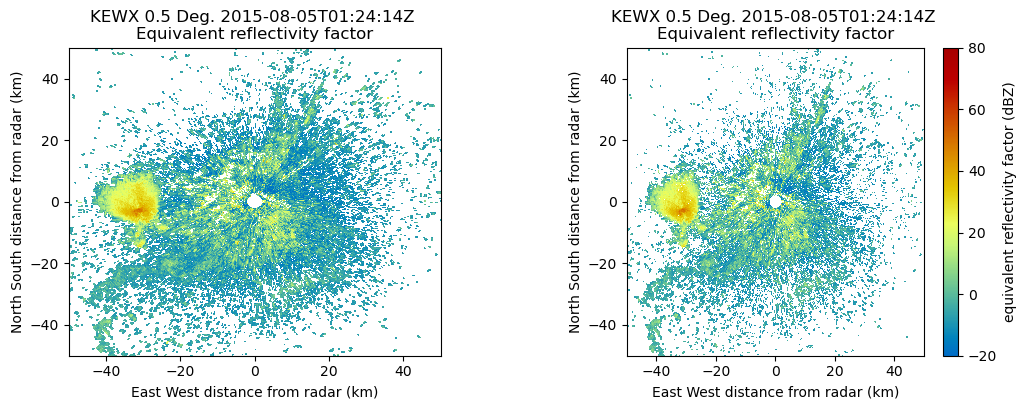

In [131]:
# Let's reset the gatefilter and try another method.
gatefilter = pyart.filters.GateFilter(radar)

# change this based on location of the bounding box
# xmin = -150
# xmax = 150
# ymin = -150
# ymax = 150

xmin = -50
xmax = 50
ymin = -50
ymax = 50
    
fig = plt.figure(figsize=(12, 4))
fig.subplots_adjust(wspace = 0.5)
display = pyart.graph.RadarDisplay(radar)
  
ax = plt.subplot(121)
    
display.plot(
    "reflectivity",
    sweep=0,
    ax=ax,
    colorbar_flag = False,
    vmin=-20,
    vmax=80
)

display.set_limits(ylim=[ymin, ymax], xlim=[xmin, xmax])

ax = plt.subplot(122)
    
gatefilter.exclude_above("cross_correlation_ratio", 0.95)
gatefilter.exclude_above("reflectivity", 60)

display.plot(
    "reflectivity",
    sweep=0,
    ax=ax,
    colorbar_flag = True, 
    vmin=-20,
    vmax=80,
    gatefilter=gatefilter
)

display.set_limits(ylim=[ymin, ymax], xlim=[xmin, xmax])